<a href="https://colab.research.google.com/github/ThuTang/Quora-Insincere-Questions-Classification/blob/master/THH_HN_ML101_Quora_Challenge_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!pip install -q kaggle

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Jul 13 15:50 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c quora-insincere-questions-classification

 83% 45.0M/54.4M [00:00<00:00, 211MB/s]
100% 54.4M/54.4M [00:00<00:00, 213MB/s]
100% 5.96G/5.96G [00:32<00:00, 188MB/s]
100% 5.96G/5.96G [00:33<00:00, 194MB/s]
  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 136MB/s]
  0% 0.00/15.7M [00:00<?, ?B/s]
100% 15.7M/15.7M [00:00<00:00, 136MB/s]


In [7]:
!unzip \*.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  

Archive:  test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.


In [10]:
## first look at our data:
quora = pd.read_csv('train.csv')
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [11]:
quora_test = pd.read_csv('test.csv')
quora_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [10]:
print(quora.shape)
print(quora_test.shape)

quora.isnull().sum()

(1306122, 3)
(375806, 2)


qid              0
question_text    0
target           0
dtype: int64

EDA part

In [11]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [12]:
X = quora.drop(['qid', 'target'], axis=1)
y = quora['target']
X.shape, y.shape

((1306122, 1), (1306122,))

In [13]:
n_0 = y.value_counts()[0]
n_1 = y.value_counts()[1]
print('{} questions are tagged as sincere.'.format(n_0))
print('{} questions are tagged as insincere.'.format(n_1))
print('{}% of the questions in the train set are tagged as insincere.'.format((n_1*100/(n_1 + n_0)).round(2)))


np.array(X[y==1])[np.random.choice(len(np.array(X[y==1])), size=15, replace=False)]


1225312 questions are tagged as sincere.
80810 questions are tagged as insincere.
6.19% of the questions in the train set are tagged as insincere.


array([['Did you know that Ukraine means fringes of Russia?'],
       ['Is it rape if she cums?'],
       ["Why can't all guys admit they will not approach her because she’s black?"],
       ['Why is the leftist media using children as a propaganda tool when the U.S. needs to protect its borders against illegal immigration?'],
       ['Why do my farts smell like that dead kid I ate last week?'],
       ['Would Severus Snape have castrated Harry Potter if he knew he could get away with it?'],
       ["Was Trump's gift of two Starbursts to Angela Merkel too great a concession?"],
       ["Why is there 112 genders when you are biologically born a male or a female? You can't physically be a cloud or a fucking banana. Don't @ me I don't want to here your whiny demigender complaints"],
       ["Why can't we rent/buy an apartment because we are Muslim? Why does it matter to people if we are Muslim or not? Everything was fixed till they saw our last name which says we are Muslim, so they chang

In [14]:
np.array(X[y==0])[np.random.choice(len(np.array(X[y==0])), size=15, replace=False)]

array([["My contract will not be renewed. I'm changing to a job that pays 35% less, working hours are 3 hours more per week, and is 30 minutes further away. How can I make the best of it?"],
       ['Can marriage in India can be registered with two different marriage dates?'],
       ['What is the cutoff of government medical colleges in Assam?'],
       ['Would it annoy you if you could hear someone’s portable IV pump in a movie theater? Should said person not go to movies because of it?'],
       ['Why did Hillary Clinton give control of a portion of US Uranium at the same time as the Clinton Foundation received nearly $125 million in gifts?'],
       ['Are you doing your masters at MIT?'],
       ['What are the best and cheapest online shopping sites in India?'],
       ['Which player will have the biggest breakthrough performance for the New York Knicks in the 2017-18 NBA season?'],
       ['How can I keep an erection when doing foreplay?'],
       ['Do you believe in philanthropic

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=1, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer', vectorizer), ('svd', svd)])

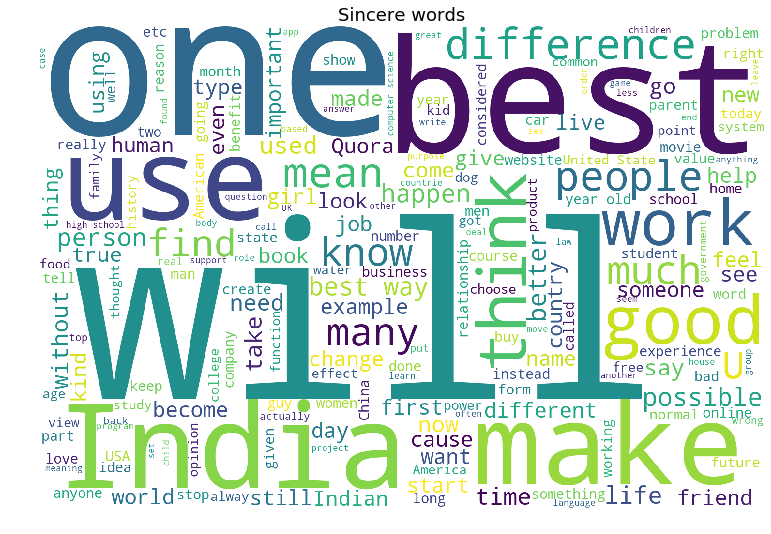

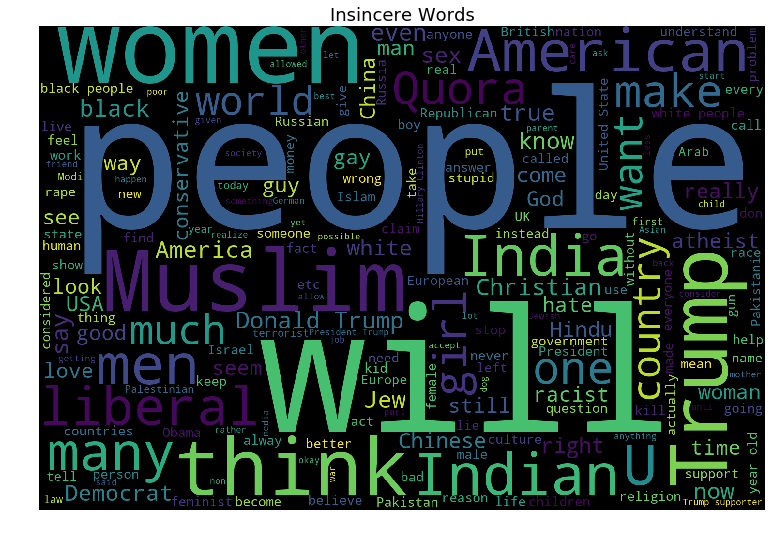

In [16]:
## word cloud:

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=1500,
                      height=1000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()

title = "Sincere words"
wordcloud_draw(quora[quora['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(quora[quora['target']==1]['question_text'], title, 'black')

In [17]:
# Building the latent semantic analysis dataframe for sincere and insincere questions

lsa_insincere = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere = pd.DataFrame(svd.components_)
topics_insincere.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

lsa_sincere = preprocessing_pipe.fit_transform(X[y==0]['question_text'])
topics_sincere = pd.DataFrame(svd.components_)
topics_sincere.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

topics_insincere.shape, topics_sincere.shape

((1, 37479), (1, 188697))

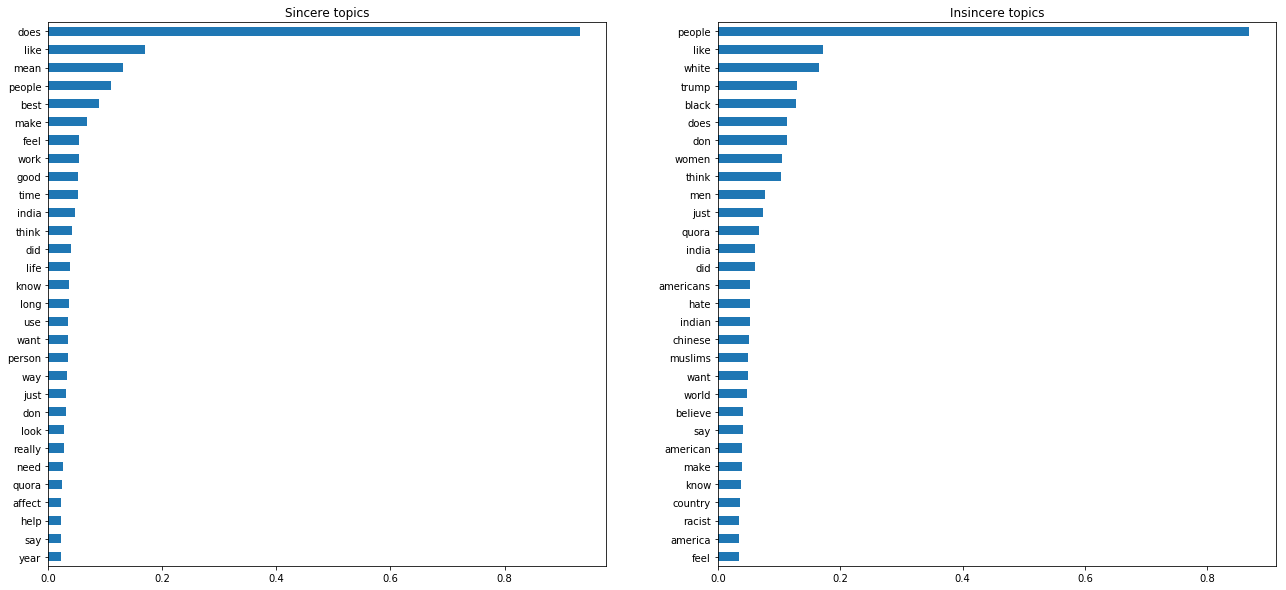

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(22,10));

topics_sincere.iloc[0].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=axes[0], title = 'Sincere topics');
topics_insincere.iloc[0].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=axes[1],title = 'Insincere topics');

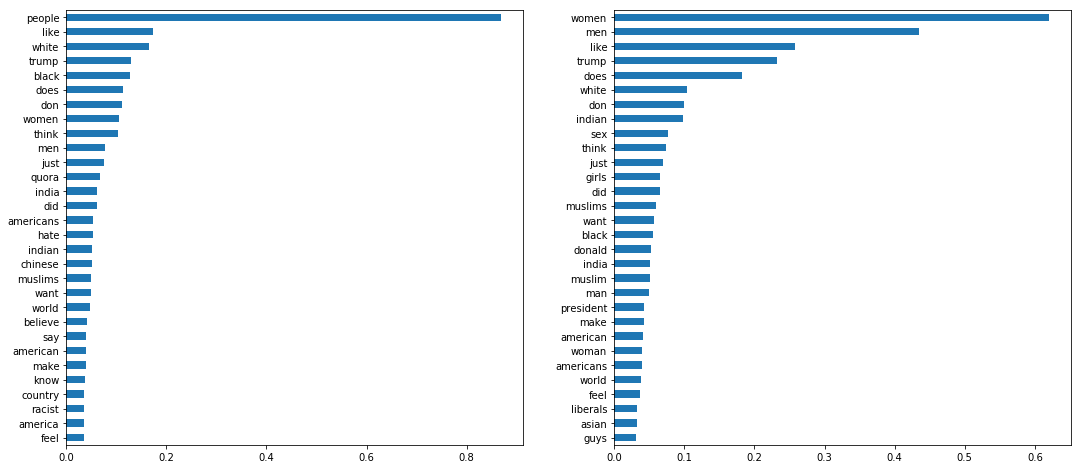

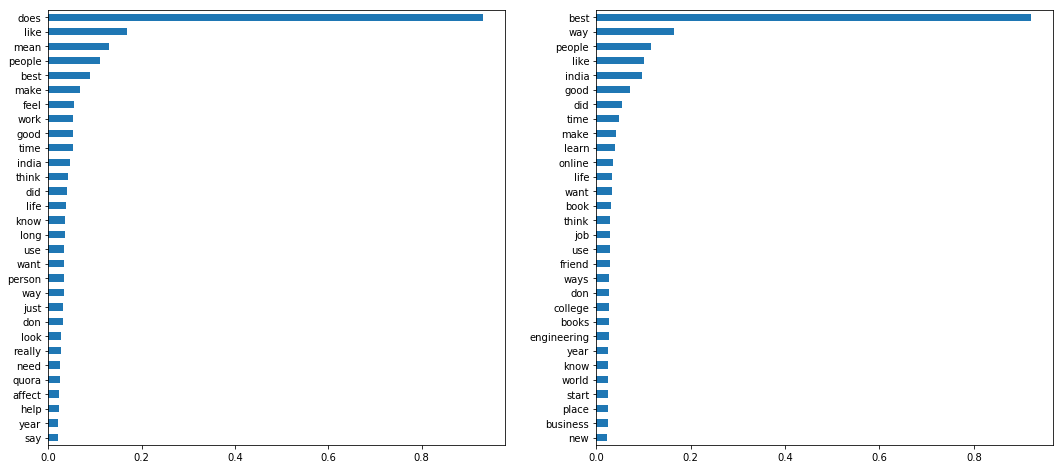

In [19]:
vectorizer = CountVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=2, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer', vectorizer), ('svd', svd)])

# Building the latent semantic analysis dataframe for sincere and insincere questions

lsa_insincere_2 = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_2 = pd.DataFrame(svd.components_)
topics_insincere_2.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()

lsa_sincere_2 = preprocessing_pipe.fit_transform(X[y==0]['question_text'])
topics_sincere_2 = pd.DataFrame(svd.components_)
topics_sincere_2.columns = preprocessing_pipe.named_steps['vectorizer'].get_feature_names()


fig_1, axes_1 = plt.subplots(1, 2, figsize=(18, 8))
for i, ax in enumerate(axes_1.flat) :
    topics_insincere_2.iloc[i].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=ax)
    
fig_2, axes_2 = plt.subplots(1, 2, figsize=(18, 8))
for i, ax in enumerate(axes_2.flat):
    topics_sincere_2.iloc[i].sort_values(ascending=False)[:30].sort_values().plot.barh(ax=ax)

In [0]:
vectorizer_22 = CountVectorizer(stop_words='english', ngram_range=(2, 2))
svd_10c = TruncatedSVD(n_components=9, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer_22', vectorizer_22), ('svd_10c', svd_10c)])

# Building the latent semantic analysis dataframe for insincere questions

lsa_insincere_10c = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_10c = pd.DataFrame(svd_10c.components_)
topics_insincere_10c.columns = preprocessing_pipe.named_steps['vectorizer_22'].get_feature_names()

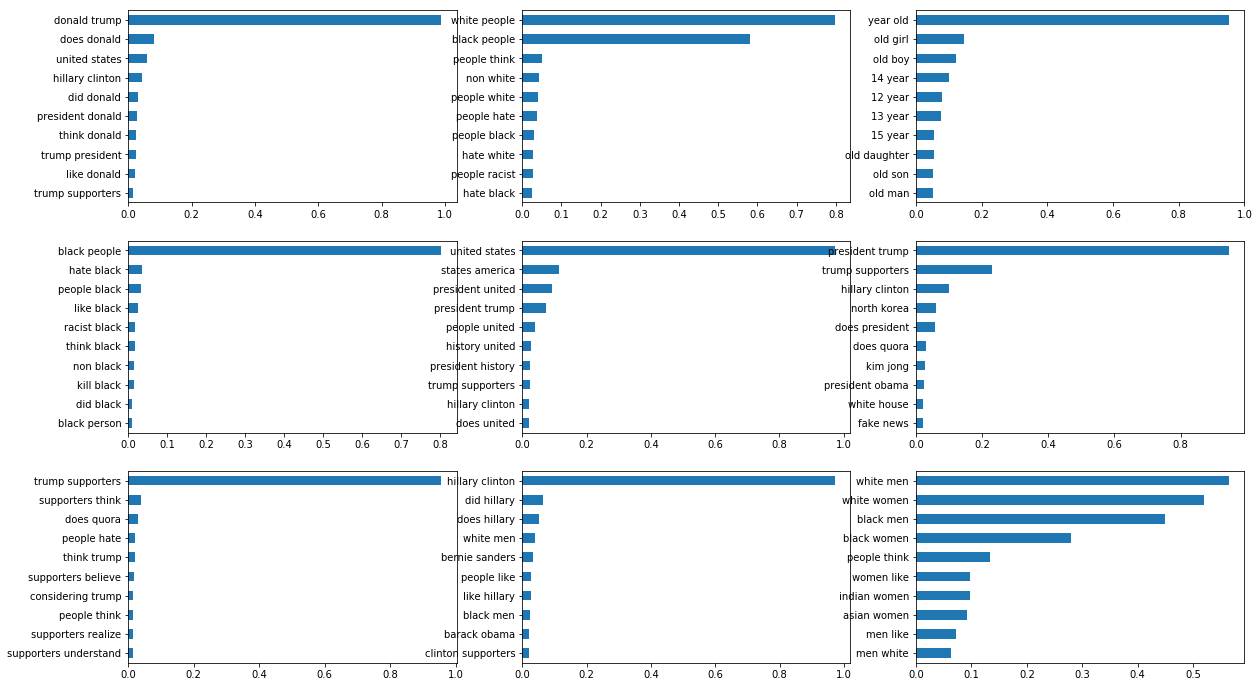

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    topics_insincere_10c.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)

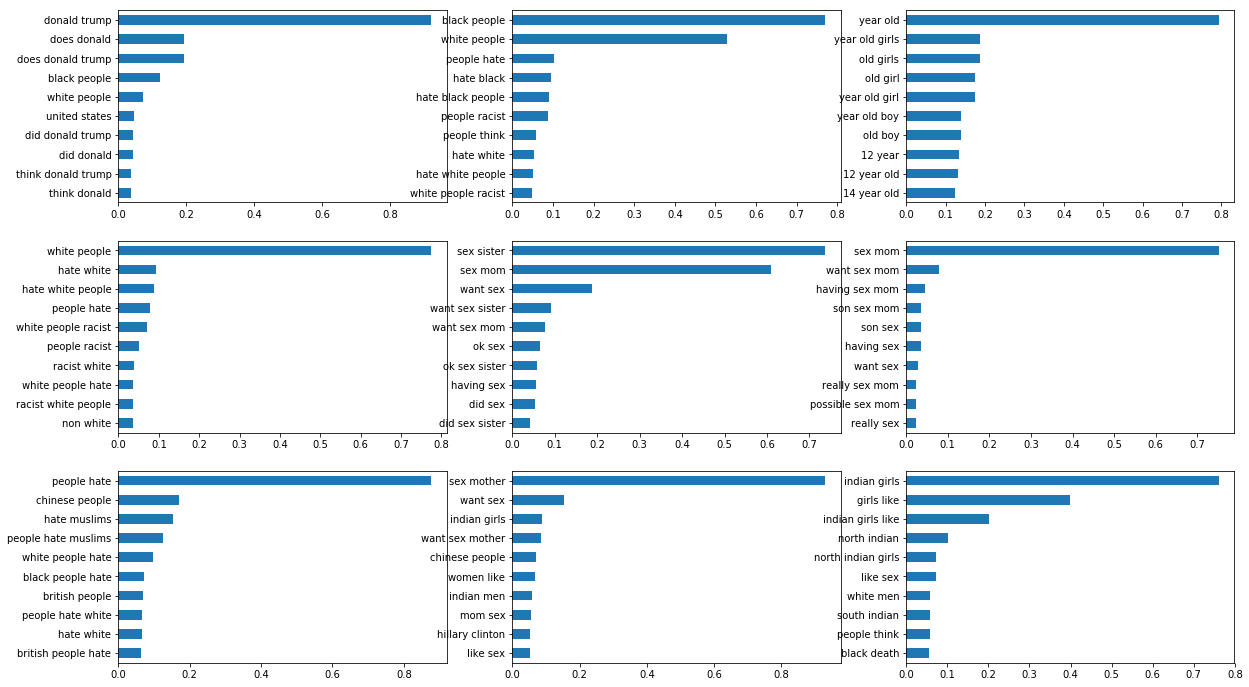

In [22]:
vectorizer_23 = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))
svd_9c = TruncatedSVD(n_components=9, random_state=42)

preprocessing_pipe = Pipeline([('vectorizer_23', vectorizer_23), ('svd_9c', svd_9c)])

# Building the latent semantic analysis dataframe for insincere questions

lsa_insincere_9c = preprocessing_pipe.fit_transform(X[y==1]['question_text'])
topics_insincere_9c = pd.DataFrame(svd_9c.components_)
topics_insincere_9c.columns = preprocessing_pipe.named_steps['vectorizer_23'].get_feature_names()

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    topics_insincere_9c.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)

Preprocessing part

In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [13]:
from tqdm import tqdm
tqdm.pandas()
## populate the vocabulary and display the first 5 elements and their count
sentences = quora["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 1306122/1306122 [00:04<00:00, 285061.67it/s]

{'How': 261930, 'did': 33489, 'Quebec': 97, 'nationalists': 91, 'see': 9003}


In [0]:
### start cleanning data, embedding part


### https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings



def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x
  
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x
  
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color','centre':'center','didnt':'did not','doesnt':'does not','isnt':'is not','shouldnt':'should not',
                'favourite':'favorite','travelling':'traveling','counselling':'counseling','theatre':'theater','labour':'labor',
                'organisation':'organization','citicise':'criticize','instagram': 'social medium','whatsapp': 'social medium',
                'snapchat': 'social medium',"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
                "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center',
                'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize',
                'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 
                'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation',
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 
                'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 
                'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'quoran': 'quora', 'quorans': 'quora', 'brexit': 'british exit', 'quoras':'quora', 'fortnite': 'video game',
                'pubg': 'video game', 'redmi': 'cell phone', 'jinping': 'chinese president', 'lyft': 'uber', 'θ': 'theta', 'σ': 'sigma'
                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [15]:
from tqdm import tqdm
tqdm.pandas()
quora["question_text"] = quora["question_text"].progress_apply(lambda x: clean_text(x))
quora["question_text"] = quora["question_text"].progress_apply(lambda x: clean_numbers(x))
quora["question_text"] = quora["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
sentences = quora["question_text"].apply(lambda x: x.split())

100%|██████████| 1306122/1306122 [00:37<00:00, 35034.93it/s]


Embedding part:

In [0]:
## split into train and valid sample with ratio 90 - 10
df_train, df_valid = train_test_split(quora, test_size=0.1, random_state=2019)


## some config values 
embed_size = 300 # how big is each word vector (in this sample)
max_features = 50000 # how many unique words to use (num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


## fill up the missing values
x_train = df_train["question_text"].fillna("_na_").values
x_valid = df_valid["question_text"].fillna("_na_").values
x_test = quora_test["question_text"].fillna("_na_").values


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
train_X = tokenizer.texts_to_sequences(x_train)
val_X = tokenizer.texts_to_sequences(x_valid)
test_X = tokenizer.texts_to_sequences(quora_test)



## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)



## Get the target values
y_train = df_train['target'].values
y_valid = df_valid['target'].values


Not using embedding and run  only RNN (try to compare the differences between simple RNN and LSTM and GRU)

In [18]:
## no embedding and simple RNN

#Adaptive Adam, the first time
# import keras.optimizers 
# from keras.optimizers import Adam
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = SimpleRNN(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_simpleRNN = Model(inputs=inp, outputs=x)
model_simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_simpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 128)          54912     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [29]:
## no embedding and CuDNNLSTM
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNLSTM(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_LSTM = Model(inputs=inp, outputs=x)
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 128)          220160    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [30]:
## no embedding and CuDNNGRU
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNGRU(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_GRU = Model(inputs=inp, outputs=x)
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100, 128)          165120    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [31]:
## Train simple RNN
model_simpleRNN.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 166s 141us/step - loss: 0.1236 - acc: 0.9530 - val_loss: 0.1111 - val_acc: 0.9553
Epoch 2/2
1175509/1175509 [==============================] - 161s 137us/step - loss: 0.1006 - acc: 0.9599 - val_loss: 0.1131 - val_acc: 0.9553


In [32]:
## Train LSTM
model_LSTM.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 102s 87us/step - loss: 0.1292 - acc: 0.9513 - val_loss: 0.1107 - val_acc: 0.9559
Epoch 2/2
1175509/1175509 [==============================] - 101s 86us/step - loss: 0.1017 - acc: 0.9593 - val_loss: 0.1118 - val_acc: 0.9568


In [33]:
## Train GRU
model_GRU.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 93s 79us/step - loss: 0.1229 - acc: 0.9536 - val_loss: 0.1099 - val_acc: 0.9565
Epoch 2/2
1175509/1175509 [==============================] - 92s 79us/step - loss: 0.0998 - acc: 0.9603 - val_loss: 0.1089 - val_acc: 0.9572


In [34]:
## Fit valid simple RNN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


pred_simpleRNN_val_y = model_simpleRNN.predict([val_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_simpleRNN_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 49us/step
F1 score at threshold 0.2 is 0.5961750021155962
F1 score at threshold 0.21 is 0.6006271747068173
F1 score at threshold 0.22 is 0.6061398918541775
F1 score at threshold 0.23 is 0.6111307733144576
F1 score at threshold 0.24 is 0.6159160236856271
F1 score at threshold 0.25 is 0.6192209683290864
F1 score at threshold 0.26 is 0.6239616023629314
F1 score at threshold 0.27 is 0.6275775003506803
F1 score at threshold 0.28 is 0.6309557639480914
F1 score at threshold 0.29 is 0.633373349339736
F1 score at threshold 0.3 is 0.6368188226143601
F1 score at threshold 0.31 is 0.6389025469564362
F1 score at threshold 0.32 is 0.6406576980568012
F1 score at threshold 0.33 is 0.6435553763982667
F1 score at threshold 0.34 is 0.6447435505251351
F1 score at threshold 0.35 is 0.6468247816875936
F1 score at threshold 0.36 is 0.647971173429422
F1 score at threshold 0.37 is 0.6497070776376208
F1 score at threshold 0.38 is 0.6509393680614859
F1 score at

In [0]:
def threshold_search(y_true, y_prob):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_prob > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'best threshold is ': best_threshold, 'and f1 score ': best_score}
    return search_result

In [36]:
search_result = threshold_search(y_valid, pred_simpleRNN_val_y)
print(search_result)


{'best threshold is ': 0.43, 'and f1 score ': 0.6558095131128208}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
length_val_X = 130613
y_pred_simpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_simpleRNN_val_y[i,0]> 0.43:
    y_pred_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_simpleRNN)))
 

[[118645   3655]
 [  2474   5839]]


In [38]:
cr = classification_report(y_valid, y_pred_simpleRNN)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122300
           1       0.62      0.70      0.66      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.95      0.95    130613



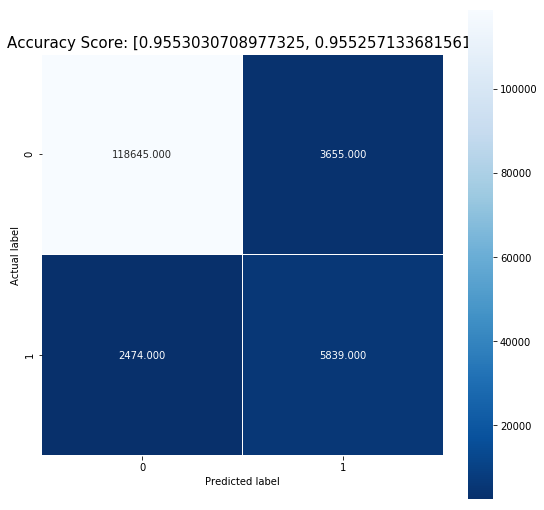

In [39]:
def draw_confusion_matrix_with_seaborn(test_label, predictions, score):
    cm = metrics.confusion_matrix(test_label, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    #plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
    plt.show()
    
    
draw_confusion_matrix_with_seaborn(y_valid, y_pred_simpleRNN, model_simpleRNN.history.history['val_acc'])  

In [43]:
## Fit valid LSTM

pred_LSTM_val_y = model_LSTM.predict([val_X], batch_size=1024, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_LSTM_val_y>thresh).astype(int))))

130613/130613 [==============================] - 3s 21us/step
F1 score at threshold 0.2 is 0.6488593254690017
F1 score at threshold 0.21 is 0.6517481044650378
F1 score at threshold 0.22 is 0.6521438082556592
F1 score at threshold 0.23 is 0.6545924967658473
F1 score at threshold 0.24 is 0.6554054054054054
F1 score at threshold 0.25 is 0.6562672252232389
F1 score at threshold 0.26 is 0.6561542319050538
F1 score at threshold 0.27 is 0.6547484773291224
F1 score at threshold 0.28 is 0.6536752136752138
F1 score at threshold 0.29 is 0.6524463864773183
F1 score at threshold 0.3 is 0.6527769717369857
F1 score at threshold 0.31 is 0.6525970219251964
F1 score at threshold 0.32 is 0.6505738965802863
F1 score at threshold 0.33 is 0.6495726495726496
F1 score at threshold 0.34 is 0.6475523631315265
F1 score at threshold 0.35 is 0.6452320058458165
F1 score at threshold 0.36 is 0.6443257840790524
F1 score at threshold 0.37 is 0.6429189857761286
F1 score at threshold 0.38 is 0.6405098088216918
F1 score 

In [44]:
search_result = threshold_search(y_valid, pred_LSTM_val_y)
print(search_result)

{'best threshold is ': 0.25, 'and f1 score ': 0.6562672252232389}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
length_val_X = 130613
y_pred_LSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_LSTM_val_y[i,0]> 0.25:
    y_pred_LSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_LSTM)))
 
cr = classification_report(y_valid, y_pred_LSTM)
print(cr)

[[118424   3876]
 [  2360   5953]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122300
           1       0.61      0.72      0.66      8313

    accuracy                           0.95    130613
   macro avg       0.79      0.84      0.82    130613
weighted avg       0.96      0.95      0.95    130613



In [46]:
## Fit valid GRU

pred_GRU_val_y = model_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_GRU_val_y>thresh).astype(int))))

130613/130613 [==============================] - 3s 21us/step
F1 score at threshold 0.2 is 0.6394941634241245
F1 score at threshold 0.21 is 0.6403430937592428
F1 score at threshold 0.22 is 0.6423007789095266
F1 score at threshold 0.23 is 0.6455497647118353
F1 score at threshold 0.24 is 0.6471702944942381
F1 score at threshold 0.25 is 0.6499093029282198
F1 score at threshold 0.26 is 0.6512944135834818
F1 score at threshold 0.27 is 0.6515175591927539
F1 score at threshold 0.28 is 0.654202603524937
F1 score at threshold 0.29 is 0.6549764572170806
F1 score at threshold 0.3 is 0.6555944055944056
F1 score at threshold 0.31 is 0.6553017764537129
F1 score at threshold 0.32 is 0.6557851930254582
F1 score at threshold 0.33 is 0.6549898625816626
F1 score at threshold 0.34 is 0.6550685087270454
F1 score at threshold 0.35 is 0.6558035458144472
F1 score at threshold 0.36 is 0.6553803339517625
F1 score at threshold 0.37 is 0.6539901708401591
F1 score at threshold 0.38 is 0.6541681405494635
F1 score a

In [47]:
search_result = threshold_search(y_valid, pred_GRU_val_y)
print(search_result)

{'best threshold is ': 0.35000000000000003, 'and f1 score ': 0.6558035458144472}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
length_val_X = 130613
y_pred_GRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_GRU_val_y[i,0]> 0.35:
    y_pred_GRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_GRU)))
 
cr = classification_report(y_valid, y_pred_GRU)
print(cr)

[[118899   3401]
 [  2598   5715]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.63      0.69      0.66      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.83      0.82    130613
weighted avg       0.96      0.95      0.96    130613



Using no embedding but using Bidirectional instead

In [49]:
## no embedding and Bidirectional simple RNN
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(SimpleRNN(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BsimpleRNN = Model(inputs=inp, outputs=x)
model_BsimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BsimpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          109824    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [50]:
## no embedding and Bidirectional CuDNNLSTM
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BLSTM = Model(inputs=inp, outputs=x)
model_BLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BLSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total para

In [51]:
## no embedding and Bidirectional CuDNNGRU
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_BGRU = Model(inputs=inp, outputs=x)
model_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_BGRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total para

In [52]:
## Train B simple RNN
model_BsimpleRNN.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 272s 232us/step - loss: 0.1259 - acc: 0.9507 - val_loss: 0.1126 - val_acc: 0.9550
Epoch 2/2
1175509/1175509 [==============================] - 272s 231us/step - loss: 0.1028 - acc: 0.9575 - val_loss: 0.1110 - val_acc: 0.9559


In [53]:
## Train BLSTM
model_BLSTM.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 181s 154us/step - loss: 0.1206 - acc: 0.9538 - val_loss: 0.1111 - val_acc: 0.9552
Epoch 2/2
1175509/1175509 [==============================] - 184s 156us/step - loss: 0.0985 - acc: 0.9607 - val_loss: 0.1084 - val_acc: 0.9571


In [54]:
## Train BGRU
model_BGRU.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 162s 138us/step - loss: 0.1205 - acc: 0.9525 - val_loss: 0.1099 - val_acc: 0.9558
Epoch 2/2
1175509/1175509 [==============================] - 162s 138us/step - loss: 0.0981 - acc: 0.9600 - val_loss: 0.1100 - val_acc: 0.9573


In [55]:
## Fit valid BsimpleRNN

pred_BsimpleRNN_val_y = model_BsimpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BsimpleRNN_val_y>thresh).astype(int))))

130613/130613 [==============================] - 14s 109us/step
F1 score at threshold 0.2 is 0.6173157386546508
F1 score at threshold 0.21 is 0.6217843970306737
F1 score at threshold 0.22 is 0.6244901830598502
F1 score at threshold 0.23 is 0.6274151687013362
F1 score at threshold 0.24 is 0.6300862531065738
F1 score at threshold 0.25 is 0.6329713721618954
F1 score at threshold 0.26 is 0.6354531797696545
F1 score at threshold 0.27 is 0.6385181426034002
F1 score at threshold 0.28 is 0.6405181720043182
F1 score at threshold 0.29 is 0.6420433855277533
F1 score at threshold 0.3 is 0.6438067102764296
F1 score at threshold 0.31 is 0.6452646760322633
F1 score at threshold 0.32 is 0.6457170721135613
F1 score at threshold 0.33 is 0.645887065795972
F1 score at threshold 0.34 is 0.647055552466218
F1 score at threshold 0.35 is 0.6474398693178618
F1 score at threshold 0.36 is 0.6482908177823432
F1 score at threshold 0.37 is 0.6472832369942196
F1 score at threshold 0.38 is 0.6465936383340167
F1 score 

In [56]:
search_result = threshold_search(y_valid, pred_BsimpleRNN_val_y)
print(search_result)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'best threshold is ': 0.36, 'and f1 score ': 0.6482908177823432}


In [57]:
length_val_X = 130613
y_pred_BsimpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BsimpleRNN_val_y[i,0]> 0.36:
    y_pred_BsimpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BsimpleRNN)))
 
cr = classification_report(y_valid, y_pred_BsimpleRNN)
print(cr)

[[118770   3530]
 [  2633   5680]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122300
           1       0.62      0.68      0.65      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.83      0.81    130613
weighted avg       0.96      0.95      0.95    130613



In [58]:
## Fit valid BLSTM

pred_BLSTM_val_y = model_BLSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BLSTM_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 46us/step
F1 score at threshold 0.2 is 0.6436702649656526
F1 score at threshold 0.21 is 0.6463855720160532
F1 score at threshold 0.22 is 0.6484723824813124
F1 score at threshold 0.23 is 0.6501799016875285
F1 score at threshold 0.24 is 0.6511913912375096
F1 score at threshold 0.25 is 0.6520275519187944
F1 score at threshold 0.26 is 0.6536386021899722
F1 score at threshold 0.27 is 0.6537484116899619
F1 score at threshold 0.28 is 0.656423982869379
F1 score at threshold 0.29 is 0.6573978901812281
F1 score at threshold 0.3 is 0.6589702905290803
F1 score at threshold 0.31 is 0.6591412129260734
F1 score at threshold 0.32 is 0.6588813767670559
F1 score at threshold 0.33 is 0.6593617622140638
F1 score at threshold 0.34 is 0.6592753457538003
F1 score at threshold 0.35 is 0.6578476113453874
F1 score at threshold 0.36 is 0.6573630736891276
F1 score at threshold 0.37 is 0.6572304788865299
F1 score at threshold 0.38 is 0.6545173009350247
F1 score a

In [59]:
search_result = threshold_search(y_valid, pred_BLSTM_val_y)
print(search_result)

{'best threshold is ': 0.33, 'and f1 score ': 0.6593617622140638}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
length_val_X = 130613
y_pred_BLSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BLSTM_val_y[i,0]> 0.33:
    y_pred_BLSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BLSTM)))
 
cr = classification_report(y_valid, y_pred_BLSTM)
print(cr)

[[118745   3555]
 [  2476   5837]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.70      0.66      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.95      0.96    130613



In [61]:
## Fit valid BGRU

pred_BGRU_val_y = model_BGRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_BGRU_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 43us/step
F1 score at threshold 0.2 is 0.6513705583756345
F1 score at threshold 0.21 is 0.6536364571546137
F1 score at threshold 0.22 is 0.6545833333333333
F1 score at threshold 0.23 is 0.6575313587013809
F1 score at threshold 0.24 is 0.6589089356250668
F1 score at threshold 0.25 is 0.6603325415676959
F1 score at threshold 0.26 is 0.6613202400436443
F1 score at threshold 0.27 is 0.6612262902514335
F1 score at threshold 0.28 is 0.6613874637519519
F1 score at threshold 0.29 is 0.6618502003725236
F1 score at threshold 0.3 is 0.661528800593709
F1 score at threshold 0.31 is 0.6595560680311329
F1 score at threshold 0.32 is 0.6594468704512373
F1 score at threshold 0.33 is 0.6580478345184227
F1 score at threshold 0.34 is 0.6560683355083641
F1 score at threshold 0.35 is 0.6555175927590962
F1 score at threshold 0.36 is 0.6534857004655662
F1 score at threshold 0.37 is 0.651040712934139
F1 score at threshold 0.38 is 0.6487053020961776
F1 score at

In [62]:
search_result = threshold_search(y_valid, pred_BGRU_val_y)
print(search_result)

{'best threshold is ': 0.29, 'and f1 score ': 0.6618502003725236}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
length_val_X = 130613
y_pred_BGRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_BGRU_val_y[i,0]> 0.29:
    y_pred_BGRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_BGRU)))
 
cr = classification_report(y_valid, y_pred_BGRU)
print(cr)

[[118759   3541]
 [  2450   5863]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.71      0.66      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.95      0.96    130613



Using embedding wiki-news-300d-1M/wiki-news-300d-1M.vec



In [19]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open('wiki-news-300d-1M/wiki-news-300d-1M.vec') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [20]:
## Using simpleRNN without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SimpleRNN(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_simpleRNN = Model(inputs=inp, outputs=x)
model_em_simpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_simpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 128)          54912     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [21]:
## Using LSTM without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = CuDNNLSTM(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_LSTM = Model(inputs=inp, outputs=x)
model_em_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 128)          220160    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [22]:
## Using GRU without Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = CuDNNGRU(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_GRU = Model(inputs=inp, outputs=x)
model_em_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100, 128)          165120    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total para

In [23]:
## Train simple RNN with embedding
model_em_simpleRNN.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 162s 138us/step - loss: 0.1163 - acc: 0.9546 - val_loss: 0.1069 - val_acc: 0.9577
Epoch 2/2
1175509/1175509 [==============================] - 159s 135us/step - loss: 0.0959 - acc: 0.9615 - val_loss: 0.1076 - val_acc: 0.9578


In [24]:
## Train LSTM with embedding
model_em_LSTM.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 107s 91us/step - loss: 0.1208 - acc: 0.9527 - val_loss: 0.1068 - val_acc: 0.9574
Epoch 2/2
1175509/1175509 [==============================] - 103s 88us/step - loss: 0.0982 - acc: 0.9595 - val_loss: 0.1100 - val_acc: 0.9582


In [25]:
## Train GRU with embedding
model_em_GRU.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 96s 82us/step - loss: 0.1137 - acc: 0.9552 - val_loss: 0.1045 - val_acc: 0.9586
Epoch 2/2
1175509/1175509 [==============================] - 95s 80us/step - loss: 0.0928 - acc: 0.9628 - val_loss: 0.1056 - val_acc: 0.9582


In [32]:
## Fit valid simpleRNN with embedding

pred_em_simpleRNN_val_y = model_em_simpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_simpleRNN_val_y>thresh).astype(int))))

130613/130613 [==============================] - 11s 86us/step
F1 score at threshold 0.2 is 0.6579082418146361
F1 score at threshold 0.21 is 0.659360066486599
F1 score at threshold 0.22 is 0.6612403507850653
F1 score at threshold 0.23 is 0.6633363447946006
F1 score at threshold 0.24 is 0.6641229578675838
F1 score at threshold 0.25 is 0.6642383385886702
F1 score at threshold 0.26 is 0.6647217482248032
F1 score at threshold 0.27 is 0.6653690006117569
F1 score at threshold 0.28 is 0.6646820939114806
F1 score at threshold 0.29 is 0.6647366030881018
F1 score at threshold 0.3 is 0.6646414856422307
F1 score at threshold 0.31 is 0.6635454598000116
F1 score at threshold 0.32 is 0.662701189643107
F1 score at threshold 0.33 is 0.6613330195893877
F1 score at threshold 0.34 is 0.6611992630890831
F1 score at threshold 0.35 is 0.6607892527287994
F1 score at threshold 0.36 is 0.6596465746792544
F1 score at threshold 0.37 is 0.6577549899285844
F1 score at threshold 0.38 is 0.656486669540053
F1 score at

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


search_result = threshold_search(y_valid, pred_em_simpleRNN_val_y)
print(search_result)

{'best threshold is ': 0.27, 'and f1 score ': 0.6653690006117569}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
length_val_X = 130613
y_pred_em_simpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_simpleRNN_val_y[i,0]> 0.27:
    y_pred_em_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_simpleRNN)))
 
cr = classification_report(y_valid, y_pred_em_simpleRNN)
print(cr)

[[118614   3686]
 [  2331   5982]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.72      0.67      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.95      0.96    130613



In [33]:
## Fit valid LSTM with embedding

pred_em_LSTM_val_y = model_em_LSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.20, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_LSTM_val_y>thresh).astype(int))))

130613/130613 [==============================] - 3s 24us/step
F1 score at threshold 0.2 is 0.6676070091683394
F1 score at threshold 0.21 is 0.6679811589440245
F1 score at threshold 0.22 is 0.6685119574844995
F1 score at threshold 0.23 is 0.6692719964269763
F1 score at threshold 0.24 is 0.6691470770618411
F1 score at threshold 0.25 is 0.6699692517936453
F1 score at threshold 0.26 is 0.6693474264705883
F1 score at threshold 0.27 is 0.6680579710144928
F1 score at threshold 0.28 is 0.6675645605199977
F1 score at threshold 0.29 is 0.6671000531883459
F1 score at threshold 0.3 is 0.6653940225496631
F1 score at threshold 0.31 is 0.6653420038535646
F1 score at threshold 0.32 is 0.6637533381888808
F1 score at threshold 0.33 is 0.6627906976744186
F1 score at threshold 0.34 is 0.6605334650530996
F1 score at threshold 0.35 is 0.6584757390545091
F1 score at threshold 0.36 is 0.6567689984901862
F1 score at threshold 0.37 is 0.6550871632329636
F1 score at threshold 0.38 is 0.6537823702002806
F1 score 

In [34]:
search_result = threshold_search(y_valid, pred_em_LSTM_val_y)
print(search_result)

{'best threshold is ': 0.25, 'and f1 score ': 0.6699692517936453}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
length_val_X = 130613
y_pred_em_LSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_LSTM_val_y[i,0]> 0.25:
    y_pred_em_LSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_LSTM)))
 
cr = classification_report(y_valid, y_pred_em_LSTM)
print(cr)

[[118934   3366]
 [  2430   5883]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.64      0.71      0.67      8313

    accuracy                           0.96    130613
   macro avg       0.81      0.84      0.82    130613
weighted avg       0.96      0.96      0.96    130613



In [37]:
## Fit valid GRU with embedding

pred_em_GRU_val_y = model_em_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_GRU_val_y>thresh).astype(int))))

130613/130613 [==============================] - 3s 21us/step
F1 score at threshold 0.2 is 0.6264224751066856
F1 score at threshold 0.21 is 0.6301567285173842
F1 score at threshold 0.22 is 0.6340460526315789
F1 score at threshold 0.23 is 0.6376892098319678
F1 score at threshold 0.24 is 0.6411626816690107
F1 score at threshold 0.25 is 0.6439260772483254
F1 score at threshold 0.26 is 0.6472678382790743
F1 score at threshold 0.27 is 0.6494074217991064
F1 score at threshold 0.28 is 0.6519711326034661
F1 score at threshold 0.29 is 0.6533247256294383
F1 score at threshold 0.3 is 0.6567688217886343
F1 score at threshold 0.31 is 0.6594052383606058
F1 score at threshold 0.32 is 0.6610334408767348
F1 score at threshold 0.33 is 0.6624203821656051
F1 score at threshold 0.34 is 0.6642625692484583
F1 score at threshold 0.35 is 0.6652596032081046
F1 score at threshold 0.36 is 0.666169578184917
F1 score at threshold 0.37 is 0.6677433247200689
F1 score at threshold 0.38 is 0.6690928843020097
F1 score a

In [38]:
search_result = threshold_search(y_valid, pred_em_GRU_val_y)
print(search_result)

{'best threshold is ': 0.39, 'and f1 score ': 0.6708305939075171}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
length_val_X = 130613
y_pred_em_GRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_GRU_val_y[i,0]> 0.39:
    y_pred_em_GRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_GRU)))
 
cr = classification_report(y_valid, y_pred_em_GRU)
print(cr)

[[118483   3817]
 [  2191   6122]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.74      0.67      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.85      0.82    130613
weighted avg       0.96      0.95      0.96    130613



In [40]:
## Using simpleRNN with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(SimpleRNN(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BsimpleRNN = Model(inputs=inp, outputs=x)
model_em_BsimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BsimpleRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          109824    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total para

In [41]:
## Using LSTM with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BLSTM = Model(inputs=inp, outputs=x)
model_em_BLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BLSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [42]:
## Using GRU with Bidirectional
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model_em_BGRU = Model(inputs=inp, outputs=x)
model_em_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_em_BGRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total para

In [43]:
## Train simple RNN with embedding
model_em_BsimpleRNN.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 273s 232us/step - loss: 0.1195 - acc: 0.9533 - val_loss: 0.1077 - val_acc: 0.9572
Epoch 2/2
1175509/1175509 [==============================] - 268s 228us/step - loss: 0.0976 - acc: 0.9612 - val_loss: 0.1074 - val_acc: 0.9580


In [44]:
## Train LSTM with embedding
model_em_BLSTM.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 190s 162us/step - loss: 0.1143 - acc: 0.9548 - val_loss: 0.1053 - val_acc: 0.9583
Epoch 2/2
1175509/1175509 [==============================] - 188s 160us/step - loss: 0.0934 - acc: 0.9627 - val_loss: 0.1052 - val_acc: 0.9583


In [45]:
## Train GRU with embedding
model_em_BGRU.fit(train_X, y_train, batch_size=512, epochs=2, validation_data=(val_X, y_valid))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 167s 142us/step - loss: 0.1167 - acc: 0.9548 - val_loss: 0.1045 - val_acc: 0.9587
Epoch 2/2
1175509/1175509 [==============================] - 165s 141us/step - loss: 0.0934 - acc: 0.9627 - val_loss: 0.1033 - val_acc: 0.9592


In [46]:
## Fit valid simpleRNN with embedding

pred_em_BsimpleRNN_val_y = model_em_BsimpleRNN.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.2, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BsimpleRNN_val_y>thresh).astype(int))))

130613/130613 [==============================] - 15s 113us/step
F1 score at threshold 0.2 is 0.6511351244175672
F1 score at threshold 0.21 is 0.6540445780115202
F1 score at threshold 0.22 is 0.6558970982934118
F1 score at threshold 0.23 is 0.6568887980376124
F1 score at threshold 0.24 is 0.658821100443894
F1 score at threshold 0.25 is 0.6601678569566805
F1 score at threshold 0.26 is 0.6609518800946621
F1 score at threshold 0.27 is 0.662096817046602
F1 score at threshold 0.28 is 0.66287736607861
F1 score at threshold 0.29 is 0.6633491994807442
F1 score at threshold 0.3 is 0.6641909234886134
F1 score at threshold 0.31 is 0.6646106399383191
F1 score at threshold 0.32 is 0.6644437034567078
F1 score at threshold 0.33 is 0.6655450874831764
F1 score at threshold 0.34 is 0.6650825978728219
F1 score at threshold 0.35 is 0.6651834103485653
F1 score at threshold 0.36 is 0.6659003390999483
F1 score at threshold 0.37 is 0.6655847919323055
F1 score at threshold 0.38 is 0.6653807937342918
F1 score at

In [47]:
search_result = threshold_search(y_valid, pred_em_BsimpleRNN_val_y)
print(search_result)

{'best threshold is ': 0.36, 'and f1 score ': 0.6659003390999483}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
length_val_X = 130613
y_pred_em_BsimpleRNN = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_simpleRNN_val_y[i,0]> 0.38:
    y_pred_em_simpleRNN[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_simpleRNN)))
 
cr = classification_report(y_valid, y_pred_em_simpleRNN)
print(cr)

[[118614   3686]
 [  2331   5982]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.72      0.67      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.95      0.96    130613



In [49]:
## Fit valid LSTM with embedding

pred_em_BLSTM_val_y = model_em_BLSTM.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BLSTM_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 48us/step
F1 score at threshold 0.25 is 0.6589792439586885
F1 score at threshold 0.26 is 0.6605876393110436
F1 score at threshold 0.27 is 0.6615541922290388
F1 score at threshold 0.28 is 0.6629549438086401
F1 score at threshold 0.29 is 0.6644822385187495
F1 score at threshold 0.3 is 0.6648824517212427
F1 score at threshold 0.31 is 0.666419609296416
F1 score at threshold 0.32 is 0.6682692307692307
F1 score at threshold 0.33 is 0.6689302074912422
F1 score at threshold 0.34 is 0.6710126032159931
F1 score at threshold 0.35 is 0.6714465546494445
F1 score at threshold 0.36 is 0.6721982520190286
F1 score at threshold 0.37 is 0.6725801952580195
F1 score at threshold 0.38 is 0.6736013494517853
F1 score at threshold 0.39 is 0.6735098962173198
F1 score at threshold 0.4 is 0.673142857142857
F1 score at threshold 0.41 is 0.6733460010364484
F1 score at threshold 0.42 is 0.6719385975113386
F1 score at threshold 0.43 is 0.6707295634339291
F1 score at

In [50]:
search_result = threshold_search(y_valid, pred_em_BLSTM_val_y)
print(search_result)

{'best threshold is ': 0.38, 'and f1 score ': 0.6736013494517853}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
length_val_X = 130613
y_pred_em_BLSTM = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_BLSTM_val_y[i,0]> 0.38:
    y_pred_em_BLSTM[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_BLSTM)))
 
cr = classification_report(y_valid, y_pred_em_BLSTM)
print(cr)

[[118818   3482]
 [  2323   5990]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.63      0.72      0.67      8313

    accuracy                           0.96    130613
   macro avg       0.81      0.85      0.82    130613
weighted avg       0.96      0.96      0.96    130613



In [53]:
## Fit valid GRU with embedding

pred_em_BGRU_val_y = model_em_GRU.predict([val_X], batch_size=512, verbose=1)

for thresh in np.arange(0.25, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (pred_em_BGRU_val_y>thresh).astype(int))))

130613/130613 [==============================] - 3s 21us/step
F1 score at threshold 0.25 is 0.6439260772483254
F1 score at threshold 0.26 is 0.6472678382790743
F1 score at threshold 0.27 is 0.6494074217991064
F1 score at threshold 0.28 is 0.6519711326034661
F1 score at threshold 0.29 is 0.6533247256294383
F1 score at threshold 0.3 is 0.6567688217886343
F1 score at threshold 0.31 is 0.6594052383606058
F1 score at threshold 0.32 is 0.6610334408767348
F1 score at threshold 0.33 is 0.6624203821656051
F1 score at threshold 0.34 is 0.6642625692484583
F1 score at threshold 0.35 is 0.6652596032081046
F1 score at threshold 0.36 is 0.666169578184917
F1 score at threshold 0.37 is 0.6677433247200689
F1 score at threshold 0.38 is 0.6690928843020097
F1 score at threshold 0.39 is 0.6708305939075171
F1 score at threshold 0.4 is 0.6707992030108479
F1 score at threshold 0.41 is 0.6700558659217877
F1 score at threshold 0.42 is 0.6705019740552736
F1 score at threshold 0.43 is 0.6706934868083653
F1 score a

In [54]:
search_result = threshold_search(y_valid, pred_em_BGRU_val_y)
print(search_result)

{'best threshold is ': 0.39, 'and f1 score ': 0.6708305939075171}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
length_val_X = 130613
y_pred_em_BGRU = np.zeros((length_val_X,), dtype = 'int')
for i in range (length_val_X):
  if pred_em_BGRU_val_y[i,0]> 0.39:
    y_pred_em_BGRU[i] = 1
    
print((confusion_matrix(y_valid, y_pred_em_BGRU)))
 
cr = classification_report(y_valid, y_pred_em_BGRU)
print(cr)

[[118483   3817]
 [  2191   6122]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122300
           1       0.62      0.74      0.67      8313

    accuracy                           0.95    130613
   macro avg       0.80      0.85      0.82    130613
weighted avg       0.96      0.95      0.96    130613

